# Regression Progressive Learner
## Moving Gaussian Experiment
When considering adversarial settings in a progressive learner, it is important to quantify the effects of an adversarial transformer on a progressive learner. In this experiment, we look at the effects of adding multiple transformers and their effects on BTE. We use transformers trained on progressively less adversarial task data as we iterate.

In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, KNNRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
# Function for generating Gaussian samples with a specific correlation and mean.
def generateGaussians(sample_size, corr, means):
    # Assign the means and covariance.
    mean = means
    cov = [[1, corr], [corr, 1]]
    # Create the multvariate normals.
    x = np.random.multivariate_normal(mean, cov, sample_size)
    # Create the outputs with the inputs.
    z = makeOutput(x)
    return x,z

In [3]:
# Function for generating Gaussian samples with a specific correlation and mean.
def makeOutput(x):
    # Return the L1 norm of the input array.
    return np.sum(np.abs(x), axis=1)

In [4]:
# Plot the distributions of the input vectors.
def plot_distributions(x1, x2, title):
    colors = sns.color_palette("Dark2", n_colors=2)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    plt.rcParams['font.size'] = '20'
    
    ax[0].scatter(x1[:,0], x1[:,1], s=50)
    ax[0].scatter(x2[:,0]-7, x2[:,1]-7, s=50)
    ax[1].scatter(x1[:,0], x1[:,1], s=50)
    ax[1].scatter(x2[:,0], x2[:,1], s=50)

    ax[0].set_xlim([-8, 8])
    ax[0].set_ylim([-8, 8])
    ax[1].set_xlim([-8, 8])
    ax[1].set_ylim([-8, 8])
    
    ax[0].set_title('Task 1', fontsize=20)
    ax[1].set_title('Task 2', fontsize=20)

    plt.tight_layout()
    plt.show()

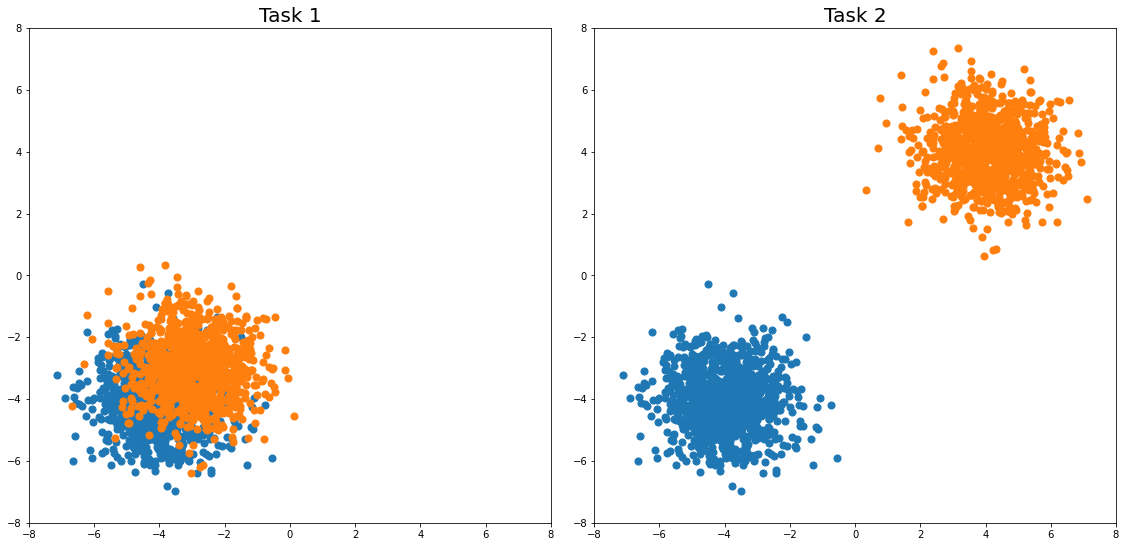

Text(0.5, 0.92, 'Task 2: L1 distance')

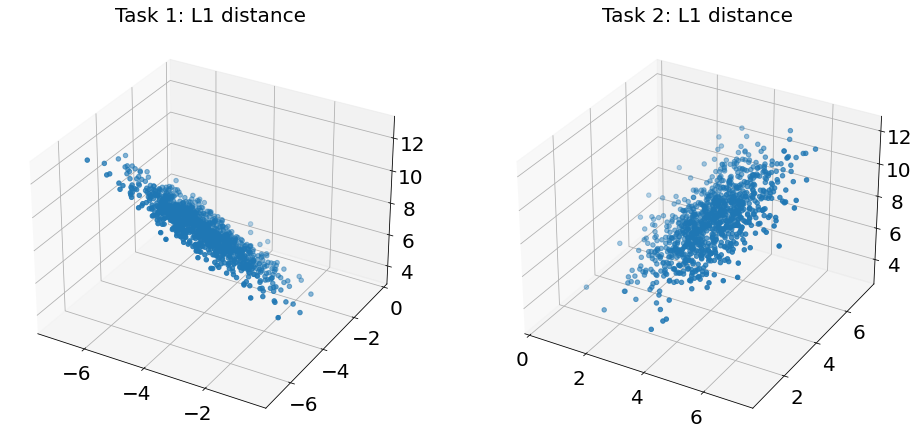

In [5]:
# Creates the means_1, means_2
means_1 = (-4,-4)
means_2 = (4,4)

# Generate Gaussians with the specific samplesize and correlation.
X1, Z1 = generateGaussians((1000), 0, means_1)
X2, Z2 = generateGaussians((1000), 0, means_2)

# Plot the distributions of the 2D data.
plot_distributions(X1, X2, ['Task 1', 'Task 2'])

# Plot the 3D distributions with the z distances.
fig = plt.figure(figsize=(16, 8))
# Add the first task data
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter3D(X1[:,0],X1[:,1], Z1)
ax1.set_title('Task 1: L1 distance', fontsize=20)

# Add the second task data
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter3D(X2[:,0],X2[:,1], Z2)
ax2.set_title('Task 2: L1 distance', fontsize=20)

"Backward transfer efficiency is the expected ratio of (i) the risk of the learned hypothesis with access to the data up to and including the last observation from task t, to (ii) the risk of the learned hypothesis with access to the entire data sequence. Thus, this quantity measures the relative effect of future task data on the performance on task t." [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf)

For the Backwards Transfer Efficiency, we first train a single learner on Task 1 data and record the mean-squared error (MSE) between the predicted and actual values on a testing set of task 1 data.This will act as the risk of the learned hypothesis with access to n=750 samples for task 1. We then train another learner on task 1 data and introduce an additional transformer trained on n=750 samples of task 2 data and record the MSE between the predicted and actual values on a testing set of task 1 data. This will act as the risk of the learned hypothesis with access to the entire data. We then take the ratio between the two values to get the BTE.

If the generalization error is lower with the additional transformer, then we can see that the BTE will be larger than 1, so backwards transfer has occurred. If the generalization error is higher with the additional transformer, then we can see that backwards transfer has not occurred.

In [6]:
print(means_2[1:10])

(4,)


In [7]:
# Set up the tree parameters.
mc_rep = 500
n_test = 1000
n_trees = 10
n_sample_size = 1000
max_depth = 10

# Set up the data parameters.
corr = 0
means_1 = (1,1)
means_2 = [(-4,-4),(-3,-3),(-2,-2),(-1,-1),(0,0),(1,1)]

print(means_1)
print(means_2)

# k_neighbors = [1,3,5,9,17,33]
k_neighbors = 1

# Set up sample sizes.
samples_task_1 = 1000
samples_task_2 = 1000

(1, 1)
[(-4, -4), (-3, -3), (-2, -2), (-1, -1), (0, 0), (1, 1)]


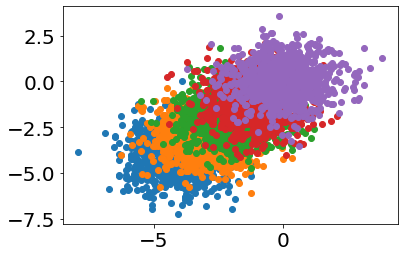

In [8]:
# See if the sample sizes for both training sets are given.
if samples_task_1 == 0 and samples_task_2 == 0:
    raise ValueError("Wake up and provide samples to train!!!")

# If acorn is specified, set random seed to it.
np.random.seed(0)

# Initialize array for storing errors, task 1, and task 2.
errors = np.zeros(2, dtype=float)

# Initialize the transformer type and arguments.
default_transformer_class = TreeRegressionTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

# Initialize the voter type and arguments.
default_voter_class = TreeRegressionVoter
default_voter_kwargs = {}

# Initialize the decider type and arguments.
default_decider_class = KNNRegressionDecider
default_decider_kwargs = {"k": k_neighbors}

# Initialize the progressive learner using the transformer, voter and decider classes.
progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class,
                                         default_decider_kwargs = default_decider_kwargs)

# Create the datasets with the Gaussian mean for task 1.
X1,Z1 = generateGaussians(samples_task_1, corr, means_1)
X1_test,Z1_test = generateGaussians(n_test, corr, means_1)

# Add a task for the task 1, predict the probabilities and add the MSE to the error array.
progressive_learner.add_task(X1, Z1,transformer_voter_decider_split=[0.33, 0.33, 0.33])
predicted_Z1 = progressive_learner.predict(X1_test, task_id=0)
errors[0] = mean_squared_error(predicted_Z1, Z1_test)

# Then, add the transformer trained on task 2, predict and add the MSE to the error array.
for i in range(len(means_2)-1):
    X2,Z2 = generateGaussians(samples_task_2, -corr, means_2[i])
    progressive_learner.add_transformer(X2, Z2)
    plt.scatter(X2[:,0], X2[:,1])

predicted_transformer_Z1 = progressive_learner.predict(X1_test, task_id=0)
errors[1] = mean_squared_error(predicted_transformer_Z1, Z1_test)

In [9]:
vote_per_transformer_id = []
transformed_per_transformer_id = []
for transformer_id in progressive_learner.task_id_to_decider[0].transformer_id_to_voters.keys():
    print(transformer_id)
    vote_per_bag_id = []
    transformed_per_bag_id = []
    prediction_per_bag_id = []
    for bag_id in range(len(progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id])):
        transformer = progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id][bag_id]
        X_transformed = transformer.transform(X1_test)
        transformed_per_bag_id.append(X_transformed)
        voter = progressive_learner.task_id_to_decider[0].transformer_id_to_voters[transformer_id][bag_id]
        vote = voter.predict(X_transformed)
        vote_per_bag_id.append(vote)
    transformed_per_transformer_id.append(np.mean(transformed_per_bag_id, axis=0))
    vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

0
1
2
3
4
5


In [11]:
print(len(np.unique(transformed_per_transformer_id)))
print(errors)

429
[0.17815682 0.07701689]


0
1
2
3
4
5


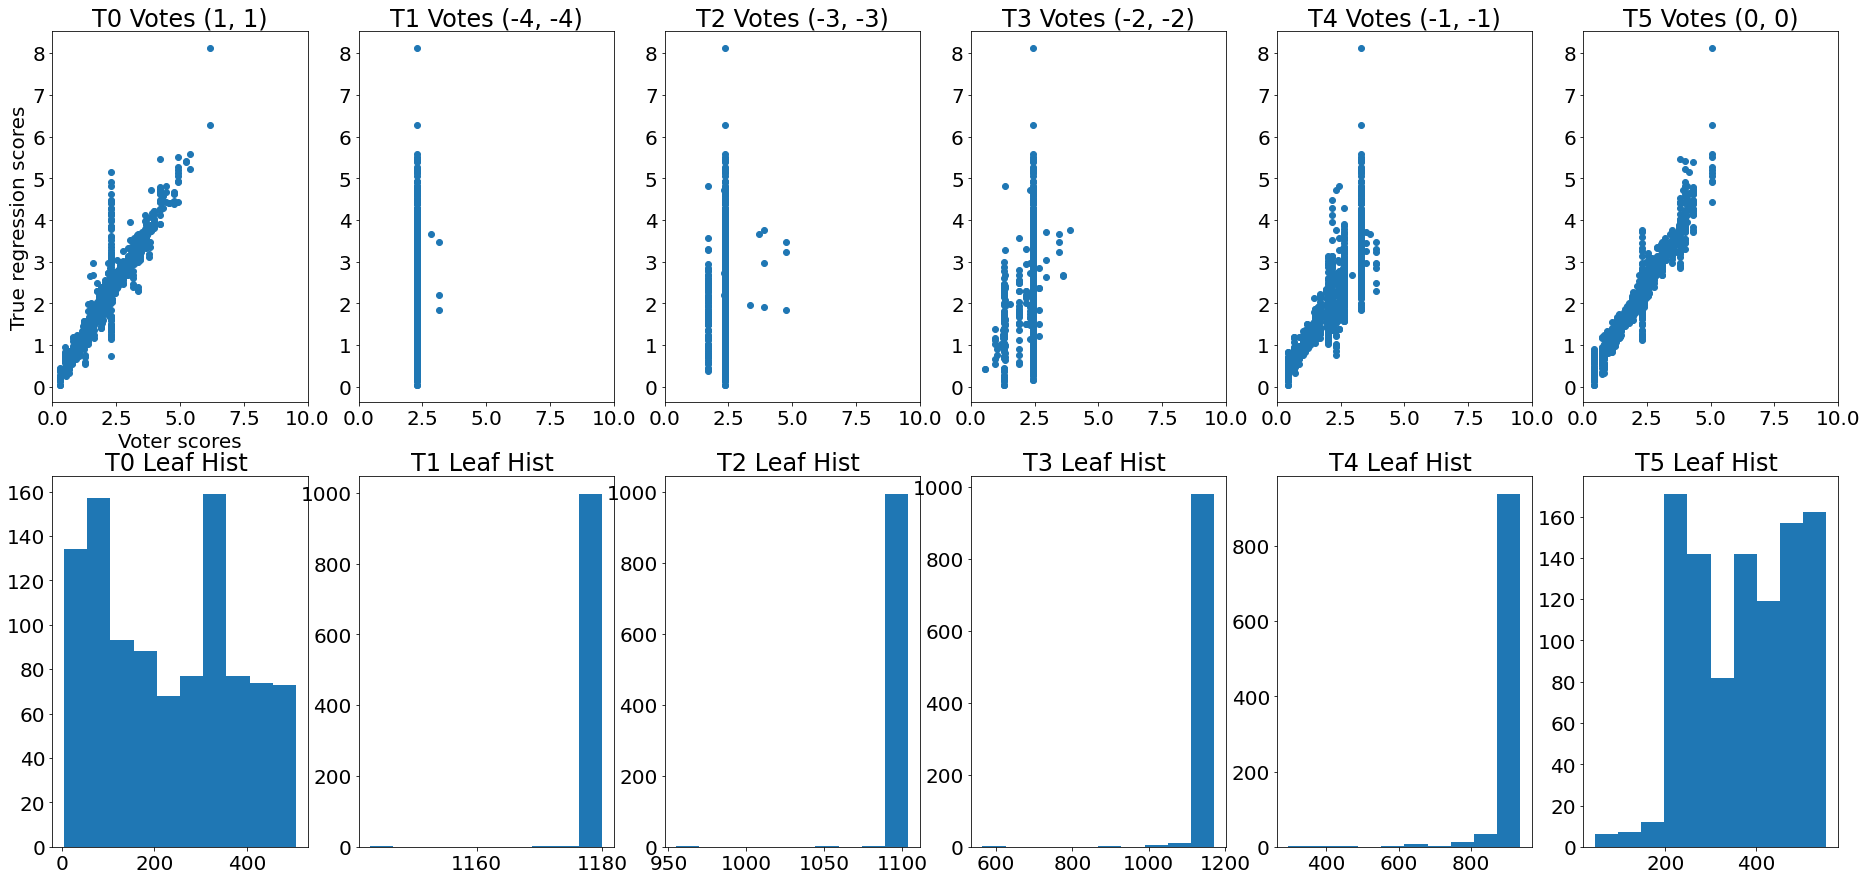

In [12]:
h = 0.05

plt.figure(figsize=(32,15))
r = 2
c = 6

for i in range(r*c):
    if i < c:
        if i == 0:
            ax = plt.subplot(r, c, i+1)
            ax.scatter(vote_per_transformer_id[i], Z1_test)
            ax.set_title('T' + str(i) + ' Votes ' + str(means_1))
            ax.set_xlabel('Voter scores')
            ax.set_ylabel('True regression scores')
        elif i > 0:
            ax = plt.subplot(r, c, i+1)
            ax.scatter(vote_per_transformer_id[i], Z1_test)
            ax.set_title('T' + str(i) + ' Votes ' + str(means_2[i-1]))
        ax.set_xlim([0,10])
    elif i >= c-1:
        if i == c-1:
            ax = plt.subplot(r, c, i+1)
            print(i-c)
            ax.hist(transformed_per_transformer_id[i-c])
            ax.set_title('T' + str(i-c) + ' Leaf Hist ')
            ax.set_xlabel('Leaf nodes')
            ax.set_ylabel('Count')
        elif i > c-1:
            print(i-c)
            ax = plt.subplot(r, c, i+1)
            ax.hist(transformed_per_transformer_id[i-c])
            ax.set_title('T' + str(i-c) + ' Leaf Hist ')

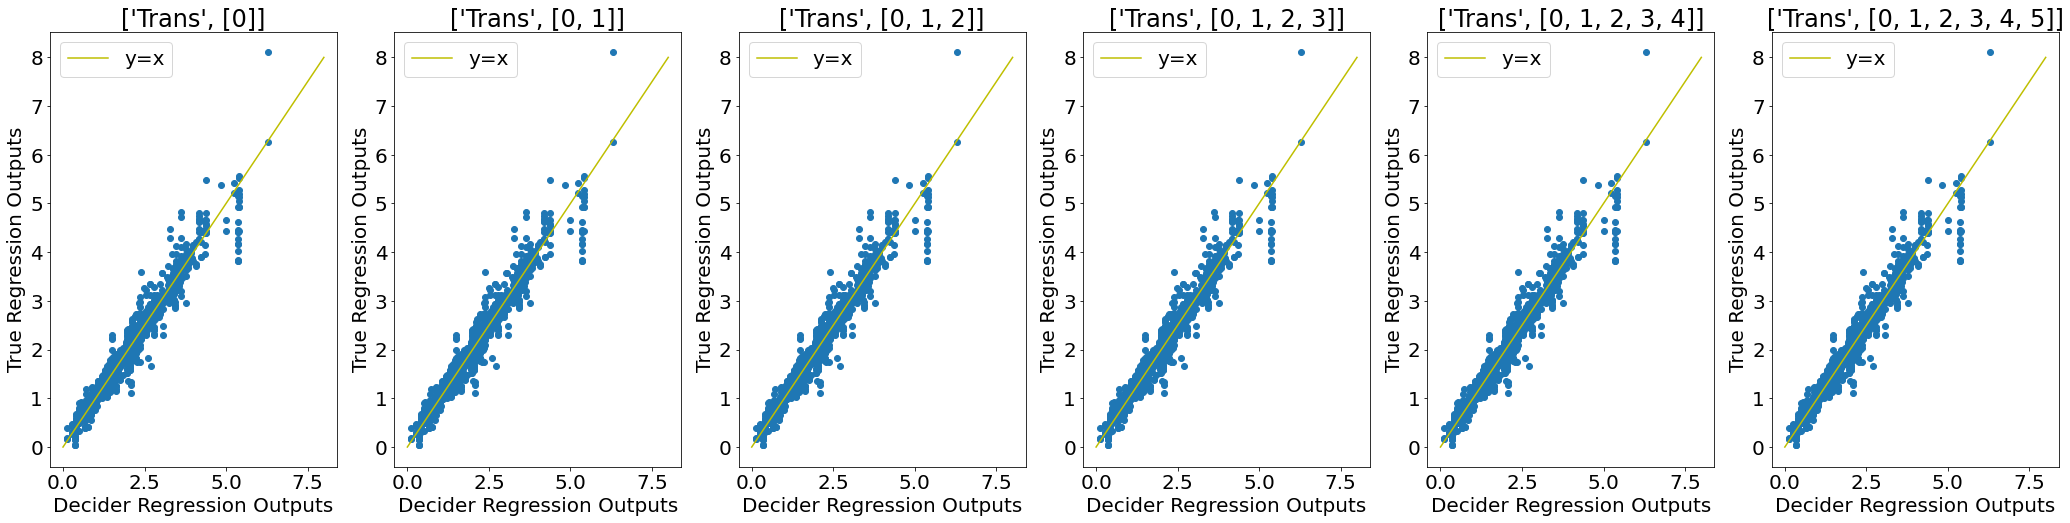

In [31]:
plt.figure(figsize=(36,8))
a = range(0,1,1)


for i in range(6):
    ran = range(0,i+1,1)
    predicted_KNN = progressive_learner.task_id_to_decider[0].predict(X1_test, transformer_ids=ran)
    
    plt.subplot(1,6,i+1)
    plt.scatter(predicted_KNN, Z1_test)
    plt.plot(range(0,9,1), range(0,9,1), 'y')
    
    plt.legend(['y=x'])
    plt.title(['Trans', list(ran)])
    plt.xlabel('Decider Regression Outputs')
    plt.ylabel('True Regression Outputs')